# Features
- initialize : random  
- epsilon : 1 to 0.1until 150000 with exponential

In [124]:
import math, random
import os, sys, time
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from common.wrappers import make_atari, wrap_deepmind, wrap_pytorch

In [7]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

## Environment

In [13]:
env_id = "DemonAttack-v0"
env    = make_atari(env_id)
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

<h3>Use Cuda</h3>

In [14]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

<h2>Replay Buffer</h2>

In [15]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, next_q_value, next_e_value, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, next_q_value, next_e_value, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, next_q_value, next_e_value, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), next_q_value, next_e_value, done
    
    def __len__(self):
        return len(self.buffer)

<h2>Computing Temporal Difference Loss</h2>

In [16]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, next_q_value, next_e_value, done = replay_buffer.sample(batch_size)
       
    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))
    

    q_values      = q_model(state)
    next_q_values = q_model(next_state)
    
    e_values      = e_model(state)
    next_e_values = e_model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    #next_q_value     = next_q_values.max(1)[0]
    next_q_value = Variable(torch.FloatTensor(np.array(next_q_value)))
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    e_value          = e_values.gather(1, action.unsqueeze(1)).squeeze(1)
    #next_e_value     = next_e_values.max(1)[0]
    next_e_value = Variable(torch.FloatTensor(np.array(next_e_value)))
    expected_e_value = gamma * next_e_value * (1 - done)
    
    q_loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
    e_loss = (e_value - Variable(expected_e_value.data)).pow(2).mean()


        
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()
    
    e_optimizer.zero_grad()
    e_loss.backward()
    e_optimizer.step()
    
    return q_loss, e_loss

In [17]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

<p><hr></p>

<h1>Atari Environment</h1>

In [144]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions, is_Evalue):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.is_Evalue = is_Evalue
        
        if is_Evalue:
            self.shift = 10
        else:
            self.shift = 0
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        if self.is_Evalue:
            x = F.sigmoid(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action
    
    def predict(self, state):
        state = Variable(torch.FloatTensor(np.float32(state)).unsqueeze(0), volatile=True)
        q_value = self.forward(state)
        return q_value
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1 and classname.find('Layer') == -1:
            nn.init.xavier_normal(m.weight)
        elif classname.find('Linear') != -1:
            #nn.init.constant(m.weight,0)
            nn.init.xavier_normal(m.weight)
            nn.init.constant(m.bias, 0.1)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

In [145]:
q_model = CnnDQN(env.observation_space.shape, env.action_space.n, False)
e_model = CnnDQN(env.observation_space.shape, env.action_space.n, True)
if USE_CUDA:
    q_model = q_model.cuda()
    e_model = e_model.cuda()
    
q_optimizer = optim.Adam(q_model.parameters(), lr=1e-4)
e_optimizer = optim.Adam(e_model.parameters(), lr=1e-4)

replay_initial = 10000
replay_buffer = ReplayBuffer(100000)

In [146]:
nn.init.constant(e_model.fc[2].weight.data,0)
nn.init.constant(e_model.fc[2].bias.data,0)


 0
 0
 0
 0
 0
 0
[torch.cuda.FloatTensor of size 6 (GPU 0)]

## Epsilon Decay

In [147]:
state = env.reset()
np.mean(q_model.predict(state).data.cpu().numpy()[0])
e_model.predict(state)

Variable containing:
 0.5000  0.5000  0.5000  0.5000  0.5000  0.5000
[torch.cuda.FloatTensor of size 1x6 (GPU 0)]

In [148]:
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay = 150000

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

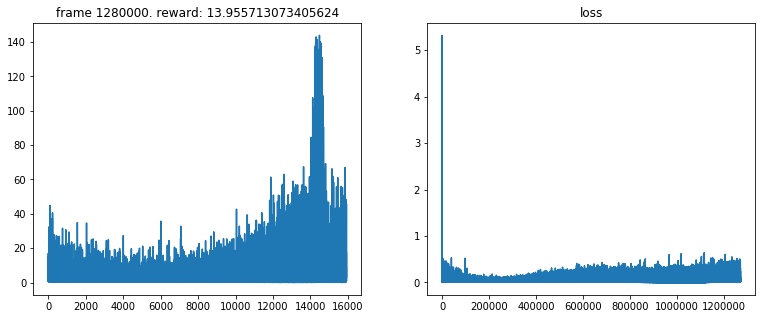

traning_speed: 208.97 1e4_frames/s
frame_idx: 1286536, (42.88 %)

In [ ]:
num_frames = 3000000
batch_size = 32
gamma      = 0.99

q_losses = []
e_losses = []
all_rewards = []
episode_reward = 0

start_time=time.time()

state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    action = q_model.act(state, epsilon)
    
    q_values = q_model.predict(state)
    e_value = e_model.predict(state).data.cpu().numpy()[0][action]
    e_bonus = 0.05/(np.sqrt(-np.log(e_value+1e-8))+1e-8)
    
    next_state, reward, done, _ = env.step(action)
    reward+= e_bonus
    
    next_action = q_model.act(next_state, 0)
    next_q_value = q_model.predict(next_state).data.cpu().numpy()[0][next_action]
    next_e_value = e_model.predict(next_state).data.cpu().numpy()[0][next_action]


    replay_buffer.push(state, action, reward, next_state, next_q_value, next_e_value, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > replay_initial:
        q_loss, e_loss = compute_td_loss(batch_size)
        q_losses.append(q_loss.data[0])
        e_losses.append(e_loss.data[0])


        
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, q_losses)
        print('\rtraning_speed: %.2f 1e4_frames/s' %(time.time()-start_time))
        start_time = time.time()
        
    print('\rframe_idx: %7d, (%.2f %%)' %(frame_idx, frame_idx/num_frames*100), end='')
    

In [143]:
e_model.predict(state)

Variable containing:
 0.4777  0.4717  0.4781  0.4807  0.4798  0.4803
[torch.cuda.FloatTensor of size 1x6 (GPU 0)]